In [1]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

plt.style.use("seaborn-whitegrid")
pd.pandas.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
#Read the dataset
df_data=pd.read_csv('C:/Users/Admin/Desktop/kaggle/kgdataset/nyc_taxi_trip_duration.csv')

df_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,29-02-2016 16:40,29-02-2016 16:47,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,11-03-2016 23:35,11-03-2016 23:53,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,21-02-2016 17:59,21-02-2016 18:26,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,05-01-2016 09:44,05-01-2016 10:03,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,17-02-2016 06:42,17-02-2016 06:56,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [3]:
#shape of dataset
df_data.shape

(729322, 11)

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


In [5]:
df_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

* The dataset has no missing values

## EDA

## Univarient Analysis

In [6]:
vendor_count = df_data.vendor_id.value_counts()

In [7]:
vendor_count

2    390481
1    338841
Name: vendor_id, dtype: int64

<AxesSubplot:ylabel='vendor_id'>

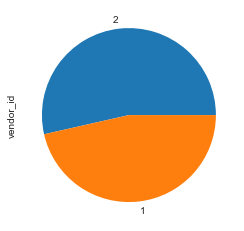

In [8]:
vendor_count.plot(kind='pie')

* there is no much difference found in vendor id

In [9]:
df_data.passenger_count.value_counts()

1    517415
2    105097
5     38926
3     29692
6     24107
4     14050
0        33
7         1
9         1
Name: passenger_count, dtype: int64

<AxesSubplot:xlabel='passenger_count', ylabel='count'>

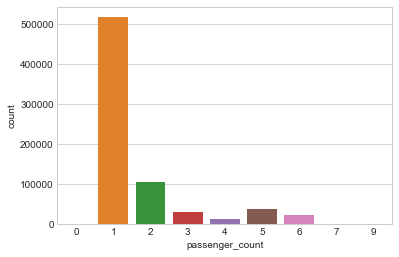

In [10]:
sns.countplot(x= 'passenger_count',data =df_data )

#majority of passenger in between 1 and 4;single passenger is more in number. #only one record found in our dataset where no.of passenger is 7 & 9

<AxesSubplot:xlabel='store_and_fwd_flag', ylabel='count'>

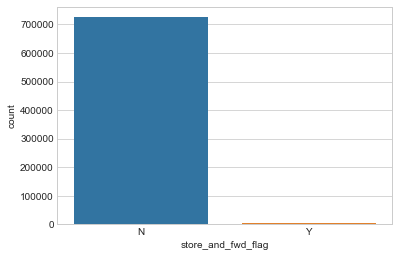

In [11]:
sns.countplot(x= 'store_and_fwd_flag',data =df_data )

## Bivariate Analysis

<AxesSubplot:>

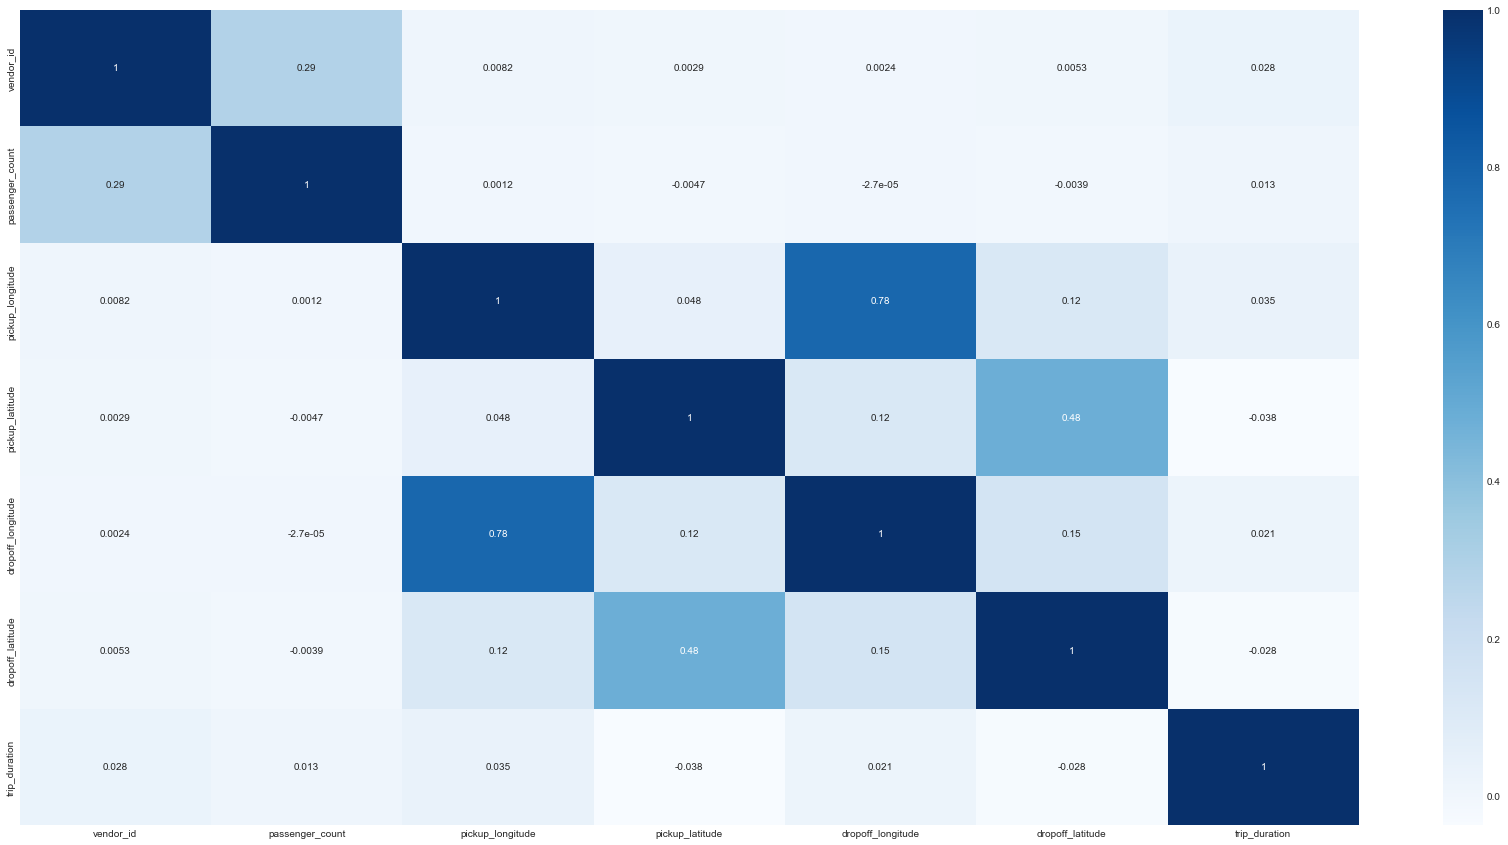

In [12]:
plt.figure(figsize=(30,15))
sns.heatmap(df_data.corr(), annot=True,cmap ='Blues')

## A. Data preprocessing

### Create new features


#create a new feature named 'trip_distance' by calculating the distance between the pickup and dropoff coordinates.
#and create another feature named 'avg_trip_speed' by considering 'trip_distance' and 'trip_duration'

In [13]:
df_data[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,729322.000000,729322.000000,729322.000000,729322.000000
mean,40.750919,-73.973513,40.751775,-73.973422
std,0.033594,0.069754,0.036037,0.069588
min,34.712235,-121.933342,32.181141,-121.933304
25%,40.737335,-73.991859,40.735931,-73.991318
50%,40.754070,-73.981758,40.754509,-73.979759
75%,40.768314,-73.967361,40.769741,-73.963036
max,51.881084,-65.897385,43.921028,-65.897385


In [14]:
#Convert into radians
df_data['pickup_latitude']=np.radians(df_data['pickup_latitude'])
df_data['pickup_longitude']=np.radians(df_data['pickup_longitude'])
df_data['dropoff_latitude']=np.radians(df_data['dropoff_latitude'])
df_data['dropoff_longitude']=np.radians(df_data['dropoff_longitude'])

#Calculate the difference
df_data['latitude_diff']=df_data['dropoff_latitude']-df_data['pickup_latitude']
df_data['longitude_diff']=df_data['dropoff_longitude']-df_data['pickup_longitude']

#calculate the distance in meter
df_data['trip_distance']=1000 * 6371 * 2 * np.arcsin(
    np.sqrt(
        np.sin(df_data['latitude_diff']/2)**2
        + np.cos(df_data['pickup_latitude'])
        * np.cos(df_data['dropoff_latitude'])
        * np.sin(df_data['longitude_diff']/2)**2
    )
)

In [15]:
#Calculate speed in m/s
df_data['avg_trip_speed']=df_data['trip_distance']/df_data['trip_duration']

In [16]:
#Function to convert datetime features into datetime datatype and extract useful information
def convert_to_date_dtype(Dataframe,col):
    #function to convert the given feature into datetime
    Dataframe[col] = pd.to_datetime(Dataframe[col], format= '%d-%m-%Y %H:%M')
    #extract required components from the datetime feature
    Dataframe[col+'_day'] = Dataframe[col].dt.dayofweek
    Dataframe[col+'_month'] = Dataframe[col].dt.month
    Dataframe[col+'_hour'] = Dataframe[col].dt.hour

In [17]:
#convert the features into datetime datatype
convert_to_date_dtype(df_data, 'pickup_datetime')
convert_to_date_dtype(df_data, 'dropoff_datetime')

df_data[['pickup_datetime', 'dropoff_datetime']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   pickup_datetime   729322 non-null  datetime64[ns]
 1   dropoff_datetime  729322 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 11.1 MB


###  Handle categorical values 

In [18]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      729322 non-null  object        
 1   vendor_id               729322 non-null  int64         
 2   pickup_datetime         729322 non-null  datetime64[ns]
 3   dropoff_datetime        729322 non-null  datetime64[ns]
 4   passenger_count         729322 non-null  int64         
 5   pickup_longitude        729322 non-null  float64       
 6   pickup_latitude         729322 non-null  float64       
 7   dropoff_longitude       729322 non-null  float64       
 8   dropoff_latitude        729322 non-null  float64       
 9   store_and_fwd_flag      729322 non-null  object        
 10  trip_duration           729322 non-null  int64         
 11  latitude_diff           729322 non-null  float64       
 12  longitude_diff          729322

In [19]:
#onehot encode and drop the first column
store_and_fwd_flag_onehot=pd.get_dummies(df_data['store_and_fwd_flag'],drop_first=True)

#concat the onehot encoded column to the main data frame
df_data=pd.concat([df_data,store_and_fwd_flag_onehot],axis=1)

In [20]:
df_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,latitude_diff,longitude_diff,trip_distance,avg_trip_speed,pickup_datetime_day,pickup_datetime_month,pickup_datetime_hour,dropoff_datetime_day,dropoff_datetime_month,dropoff_datetime_hour,Y
0,id1080784,2,2016-02-29 16:40:00,2016-02-29 16:47:00,1,-1.290739,0.711726,-1.290913,0.711591,N,400,-0.000135,-0.000174,1199.072370,2.997681,0,2,16,0,2,16,0
1,id0889885,1,2016-03-11 23:35:00,2016-03-11 23:53:00,2,-1.291340,0.710903,-1.291452,0.710261,N,1100,-0.000642,-0.000112,4129.111152,3.753737,4,3,23,4,3,23,0
2,id0857912,2,2016-02-21 17:59:00,2016-02-21 18:26:00,2,-1.291497,0.710724,-1.290637,0.711657,N,1635,0.000933,0.000860,7250.752272,4.434711,6,2,17,6,2,18,0
3,id3744273,2,2016-01-05 09:44:00,2016-01-05 10:03:00,6,-1.290875,0.711391,-1.290789,0.711756,N,1141,0.000365,0.000085,2361.096710,2.069322,1,1,9,1,1,10,0
4,id0232939,1,2016-02-17 06:42:00,2016-02-17 06:56:00,1,-1.291842,0.710497,-1.291337,0.711058,N,848,0.000561,0.000505,4328.533483,5.104403,2,2,6,2,2,6,0


<AxesSubplot:>

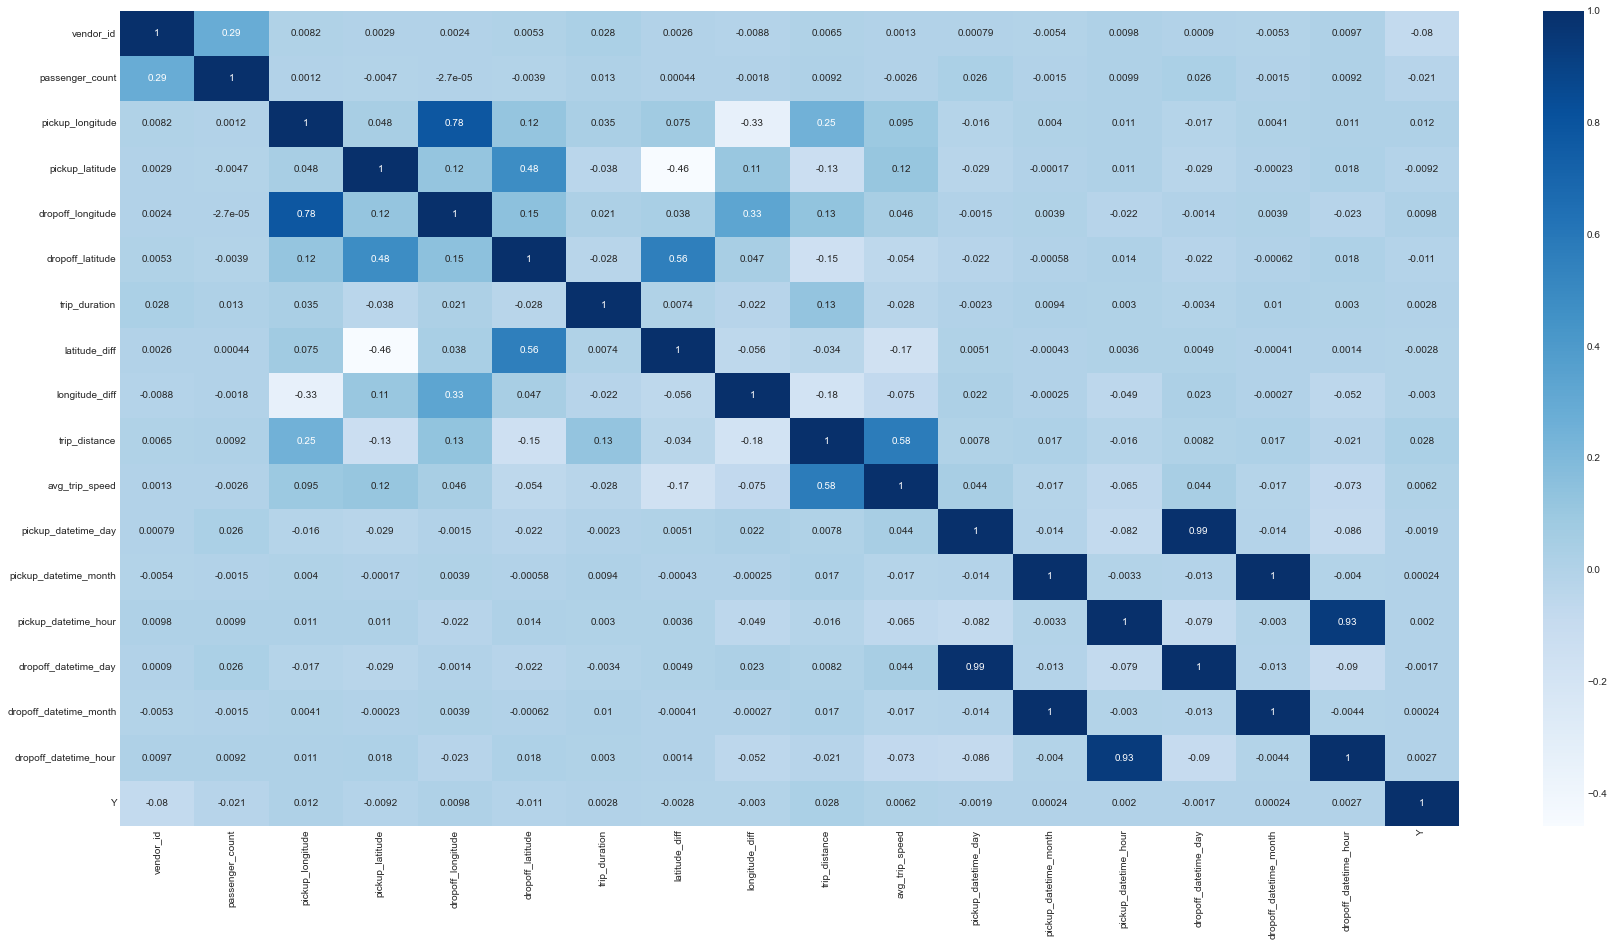

In [21]:
plt.figure(figsize=(30,15))
sns.heatmap(df_data.corr(), annot=True,cmap ='Blues')

###  Dropping features that are not required

In [22]:
df_data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'latitude_diff', 'longitude_diff', 'trip_distance',
       'avg_trip_speed', 'pickup_datetime_day', 'pickup_datetime_month',
       'pickup_datetime_hour', 'dropoff_datetime_day',
       'dropoff_datetime_month', 'dropoff_datetime_hour', 'Y'],
      dtype='object')

In [23]:
drop_cols=['id','pickup_datetime', 'dropoff_datetime','pickup_longitude', 'pickup_latitude',
          'dropoff_longitude', 'dropoff_latitude','store_and_fwd_flag','latitude_diff','longitude_diff']

df_data.drop(drop_cols,axis=1,inplace=True)

In [24]:
#make sure the columns have been dropped
df_data.columns

Index(['vendor_id', 'passenger_count', 'trip_duration', 'trip_distance',
       'avg_trip_speed', 'pickup_datetime_day', 'pickup_datetime_month',
       'pickup_datetime_hour', 'dropoff_datetime_day',
       'dropoff_datetime_month', 'dropoff_datetime_hour', 'Y'],
      dtype='object')

* keep only relevent continous datas

###  Treat 'vendor_id' as an object

In [25]:
df_data['vendor_id']=pd.get_dummies(df_data['vendor_id'],drop_first=True)

In [26]:
df_data.dtypes

vendor_id                   uint8
passenger_count             int64
trip_duration               int64
trip_distance             float64
avg_trip_speed            float64
pickup_datetime_day         int64
pickup_datetime_month       int64
pickup_datetime_hour        int64
dropoff_datetime_day        int64
dropoff_datetime_month      int64
dropoff_datetime_hour       int64
Y                           uint8
dtype: object

###  Transform target feature=trip_duration

count    7.293220e+05
mean     9.522291e+02
std      3.864626e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.630000e+02
75%      1.075000e+03
max      1.939736e+06
Name: trip_duration, dtype: float64

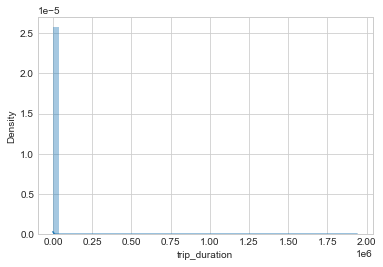

In [27]:
#Before transformation
sns.distplot(a=df_data['trip_duration'], bins=50)
df_data['trip_duration'].describe()

<AxesSubplot:xlabel='trip_duration', ylabel='Density'>

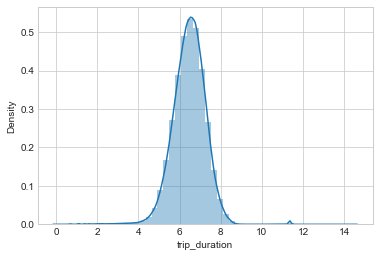

In [28]:
#After transformation
df_data['trip_duration']=np.log(df_data['trip_duration'])
sns.distplot(a=df_data['trip_duration'],bins=50)

##  Model Building

In [29]:
#seperate dependent and independent features
X=df_data.drop(['trip_duration'],axis=1)
y=df_data['trip_duration']

In [30]:
# Break off dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=10)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (510525, 11) (510525,)
Test (218797, 11) (218797,)


### Linear Regression Model

In [31]:
lr_model=LinearRegression()

lr_model.fit(X_train,y_train)

LinearRegression()

In [32]:
pred=lr_model.predict(X_test)

In [33]:
print('MAE:', mean_absolute_error(y_test, pred))
print('MSE:', mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))
print('R2', r2_score(y_test,pred))

MAE: 0.3752242560674227
MSE: 0.2981317650172613
RMSE: 0.5460144366381362
R2 0.5277882117960686


#LOSS FUCTION IS RMSE,SO WE ARE GOING TO TRY  DIFFERENT ML REGRESSOR ALGORITHMS AND CHECK THE RMSE VALUE

## Trying with different alogorithms

In [34]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import GammaRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [35]:
#pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [36]:
import xgboost as xg


In [38]:
dt = DecisionTreeRegressor()
knn = KNeighborsRegressor()
br = BaggingRegressor()
xgb_r = xg.XGBRegressor()
gb_reg = GradientBoostingRegressor()

In [39]:
#DecisionTree
dt.fit(X_train,y_train)
pred_dt=dt.predict(X_test)
RMSE_dt = np.sqrt(mean_squared_error(y_test, pred_dt))
#print('RMSE_dt':RMSE_dt)
#print('RMSE_dt =', np.sqrt(mean_squared_error(y_test, pred_dt)))
print('R2_dt =', r2_score(y_test,pred_dt))

R2_dt = 0.968437089582574


In [40]:
RMSE_dt

0.1411640906036569

In [41]:
#KNeighbors
knn.fit(X_train,y_train)
pred_knn=knn.predict(X_test)

                 
#print('RMSE_knn =', np.sqrt(mean_squared_error(y_test, pred_knn)))
print('R2_knn =', r2_score(y_test,pred_knn))
RMSE_knn = np.sqrt(mean_squared_error(y_test, pred_knn))

R2_knn = 0.8084318221281145


In [42]:
RMSE_knn


0.3477742298647818

In [43]:
#BaggingRegressor
br.fit(X_train,y_train)
pred_br=br.predict(X_test)

#print('RMSE_br =', np.sqrt(mean_squared_error(y_test, pred_br)))
print('R2_br =', r2_score(y_test,pred_br))
RMSE_br = np.sqrt(mean_squared_error(y_test, pred_br))

R2_br = 0.9784760071113965


In [44]:
RMSE_br

0.11657277456506854

In [45]:
#XGBRegressor
#xgb_r = xg.XGBRegressor()
xgb_r.fit(X_train,y_train)
pred_xgb_r=xgb_r.predict(X_test)

#print('RMSE_xgb_r =', np.sqrt(mean_squared_error(y_test, pred_xgb_r)))
print('R2_xgb_r =', r2_score(y_test,pred_xgb_r))
RMSE_xgb_r = np.sqrt(mean_squared_error(y_test, pred_xgb_r))

R2_xgb_r = 0.9835252826224913


In [46]:
RMSE_xgb_r

0.10198697250074942

In [47]:
#GradientBoostingRegressor
#gb_reg = GradientBoostingRegressor()
gb_reg.fit(X_train,y_train)
pred_gb_reg=gb_reg.predict(X_test)

#print('RMSE_gb_reg =', np.sqrt(mean_squared_error(y_test, pred_gb_reg)))
print('R2_gb_reg =', r2_score(y_test,pred_gb_reg))
RMSE_gb_reg = np.sqrt(mean_squared_error(y_test, pred_gb_reg))

R2_gb_reg = 0.9784090837961343


In [48]:
RMSE_gb_reg

0.11675386043173415

In [49]:
li = [dt,knn,br,xgb_r,gb_reg]
di = {}
for i in li:
    i.fit(X_train,y_train)
    ypred = i.predict(X_test)
    print(i,":",r2_score(ypred,y_test)*100)
    di.update({str(i):i.score(X_test,y_test)*100})

DecisionTreeRegressor() : 96.7740208308998
KNeighborsRegressor() : 74.60951647394619
BaggingRegressor() : 97.72717589886662
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...) : 98.33070659744546
GradientBoostingRegressor() : 97.6926020037798


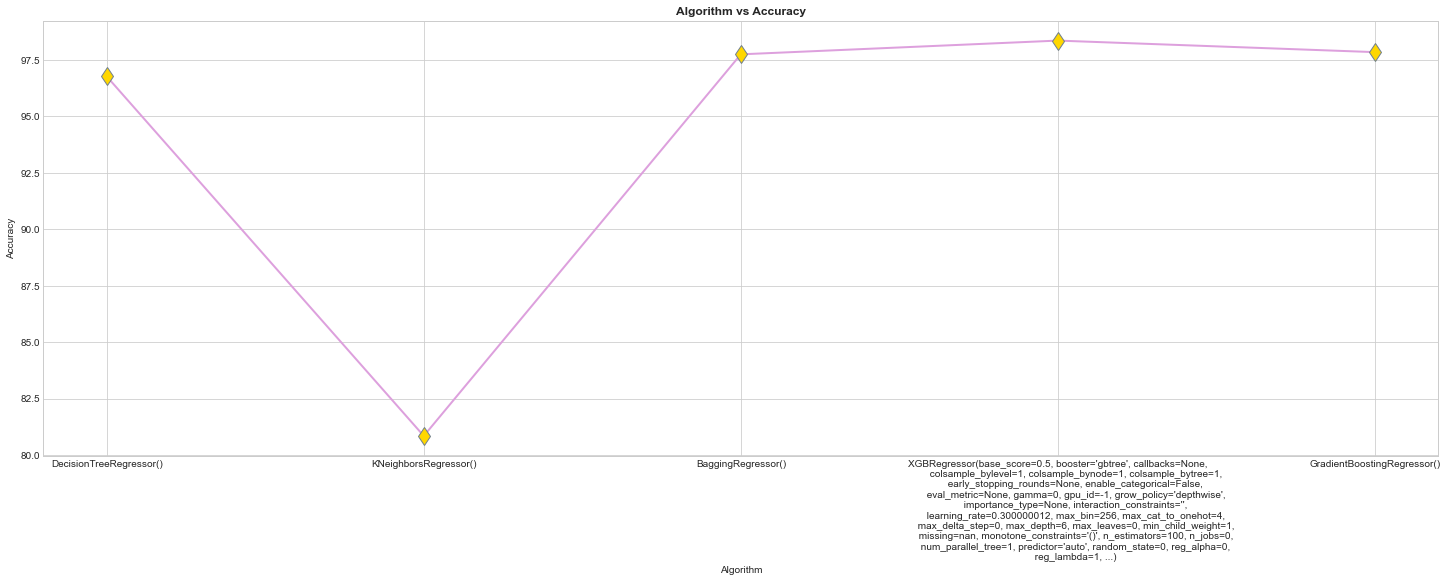

In [50]:
plt.figure(figsize=(25, 8))
plt.title("Algorithm vs Accuracy", fontweight='bold')
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
y = np.arange(50, 100) 
plt.plot(di.keys(),di.values(),marker='d',color='plum',linewidth=2,markersize=13,
         markerfacecolor='gold',markeredgecolor='slategray')
plt.show()

In [51]:
COMP_TABLE=pd.DataFrame({'Classification Model':['Decesion Tree','KNN',"Bagging Regressor",'XGB Regressor','Gradient Boost Regressor'],
                          'RMSE':[RMSE_dt, RMSE_knn,
                                      RMSE_br, RMSE_xgb_r, RMSE_gb_reg]})

In [52]:
COMP_TABLE

,Classification Model,RMSE
0,Decesion Tree,0.141164
1,KNN,0.347774
2,Bagging Regressor,0.116573
3,XGB Regressor,0.101987
4,Gradient Boost Regressor,0.116754


### Conclusion

* found XGBRegressor is the best,it has comparitivly less RMSE value(0.101987) and high accuracy level=98.33%

### THE END